# Rating Distribution Analysis for GAP (on Amazon)

In [2]:
#importing required packages
import requests
from bs4 import BeautifulSoup
from textblob import TextBlob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import random
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
#intializing the options object to be fed into webdriver parameters
chrome_options=Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

In [4]:
# Add a custom User-Agent
user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
chrome_options.add_argument(f'user-agent={user_agent}')

In [5]:
'''
Adding the property to not let program close the browser window post execution
This comes quite handy while visualizing how browser content are changing during 
execution and what was the last state of browser
'''
chrome_options.add_experimental_option("detach", True)

In [6]:
#starting the chrome driver
driver=webdriver.Chrome(options=chrome_options)

In [7]:
#setting up the target website ot be scrapped
target='https://www.amazon.com/s?k=GAP+Clothing&ref=cs_503_search'

In [8]:
#getting the web page
driver.get(target)
#waiting for the page to load
time.sleep(random.uniform(2, 10))
#maximizing the browser window
driver.maximize_window()

In [9]:
# Store product data
product_data = {
    "Product Name": [],
    "Price": [],
    "Rating": [],
    "Review Count": []
}

In [10]:
page_number=1
while page_number<7:
    #selecting a product block
    products = driver.find_elements(By.XPATH, '//div[contains(@class, "s-main-slot")]/div[@data-component-type="s-search-result"]')
    # Iterate over the products and extract details
    for product in products:
        if product.find_element(By.XPATH,'.//h2[@class="a-size-mini s-line-clamp-1"]').text=='GAP':
            try:
                # Product Name
                product_name = product.find_element(By.XPATH,'.//span[@class="a-size-base-plus a-color-base a-text-normal"]').text
            except:
                product_name = 'N/A'

            try:
                # Price
                price = product.find_element(By.XPATH, './/span[@class="a-price-whole"]').text
                price_fraction = product.find_element(By.XPATH, './/span[@class="a-price-fraction"]').text
                full_price = f"{price}.{price_fraction}"
            except:
                full_price = 'N/A'

            try:
                # Rating
                rating = product.find_element(By.XPATH, './/span[@class="a-icon-alt"]').get_attribute('innerHTML').split()[0]
            except:
                rating = 'N/A'

            try:
                # Review Count
                review_count = product.find_element(By.XPATH, './/span[@class="a-size-base s-underline-text"]').text
            except:
                review_count = 'N/A'

            # Store the product details in the dictionary
            product_data["Product Name"].append(product_name)
            product_data["Price"].append(full_price)
            product_data["Rating"].append(rating)
            product_data["Review Count"].append(review_count)
        else:
            pass
    
    try:
        #incrementing the page number
        page_number+=1
        #wait till the next button appears and then locate it
        button = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.XPATH, '//a[contains(@class, "s-pagination-next")]'))
        )
        # Click the "Next" button
        button.click()
        
        #waiting for the page to load
        time.sleep(10)
    except:
        print(page_number)
        print("No 'Next' button found. Ending the loop.")
        break


In [11]:
df = pd.DataFrame(product_data)

In [12]:
df.shape

(295, 4)

In [13]:
df.tail()

,Product Name,Price,Rating,Review Count
290,baby-girls Crochet Set,24.31,N/A,N/A
291,Baby-Girls Short Sleeve Logo T-shirt,11.38,4.8,149
292,Women's Logo Microfleece Hoodie Hooded Sweatshirt,N/A,3.8,14
293,baby-boys Henley Romper,19.32,4.7,41
294,Girls Logo Pullover Hoody and Jogger Set,39.74,N/A,N/A


In [14]:
# Convert 'Rating' and 'Review Count' columns to numeric, forcing errors to NaN for missing values
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df['Review Count'] = pd.to_numeric(df['Review Count'], errors='coerce')

## Plot for Top 10 Most Popular Items based on Review Count

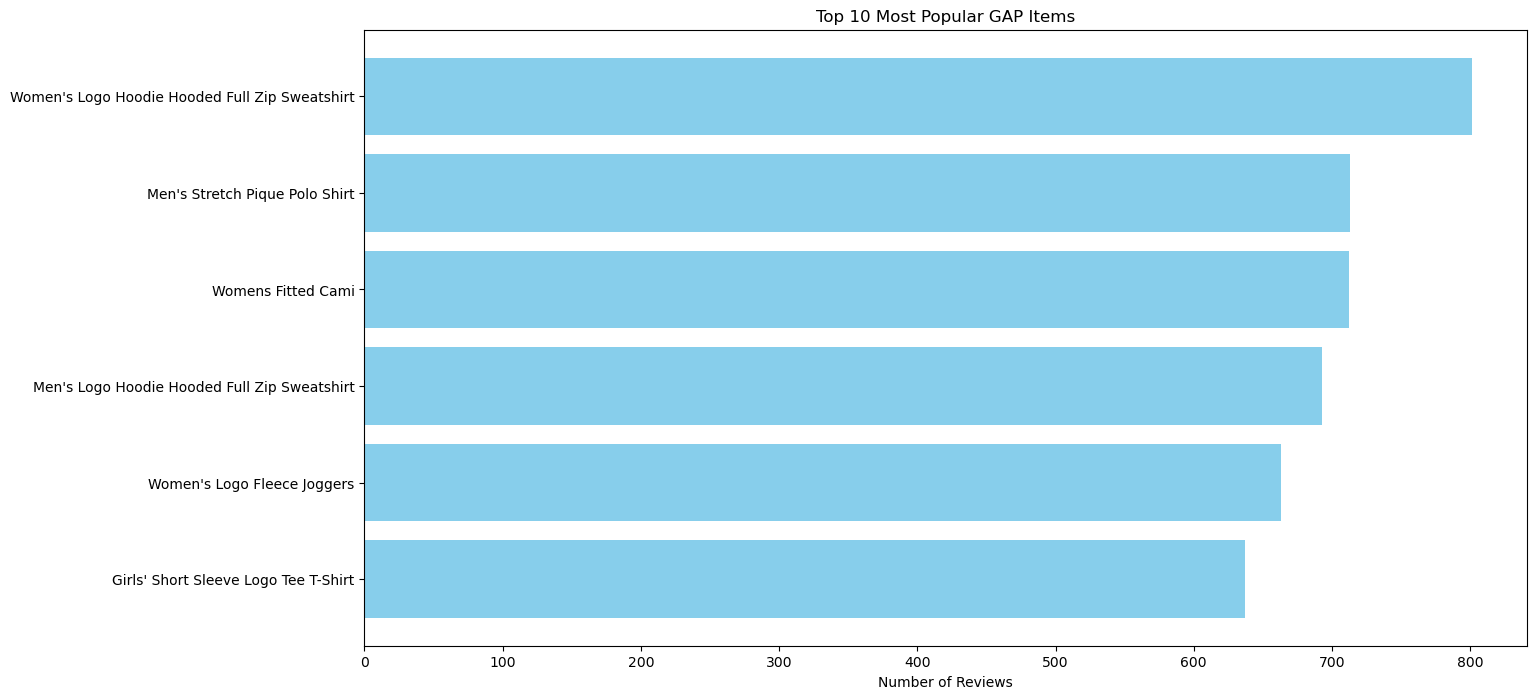

In [28]:
#visualization 1
#filtering by top review counts
top_popular_items = df.nlargest(10, 'Review Count')

plt.figure(figsize=(15, 8))
plt.barh(top_popular_items['Product Name'], top_popular_items['Review Count'], color='skyblue')
plt.xlabel('Number of Reviews')
plt.title('Top 10 Most Popular GAP Items')
plt.gca().invert_yaxis()  # Invert y-axis to show the most popular items on top
plt.show()

##  Distribution of Ratings

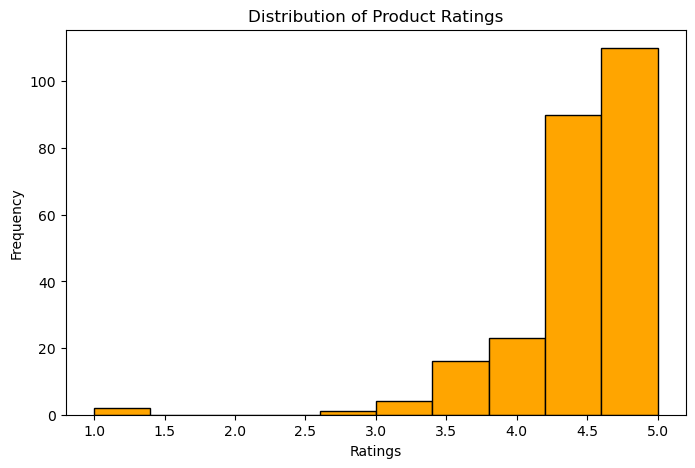

In [16]:
#visualization 2
plt.figure(figsize=(8, 5))
plt.hist(df['Rating'].dropna(), bins=10, color='orange', edgecolor='black')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Distribution of Product Ratings')
plt.show()

## Items with Lowest Ratings (Badly Reviewed)

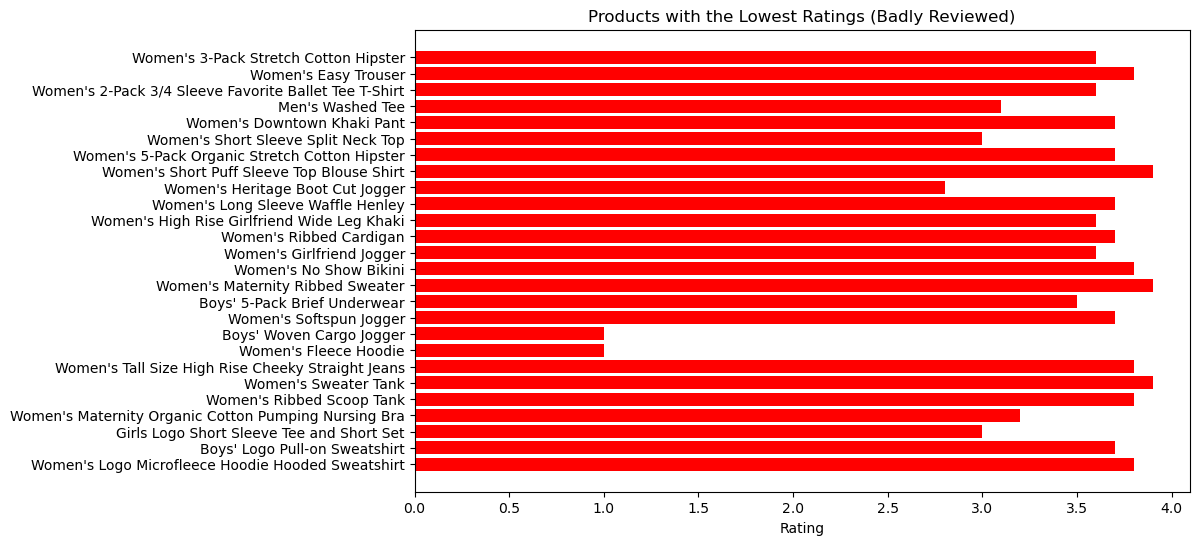

In [17]:
#visualization 3
# Assuming items with ratings below 4.0 are considered badly reviewed
badly_reviewed_items = df[df['Rating'] < 4.0]

plt.figure(figsize=(10, 6))
plt.barh(badly_reviewed_items['Product Name'], badly_reviewed_items['Rating'], color='red')
plt.xlabel('Rating')
plt.title('Products with the Lowest Ratings (Badly Reviewed)')
plt.gca().invert_yaxis()  # Invert y-axis to show the lowest ratings on top
plt.show()

## Elasticity Analysis (Review Count v/s Price, Ratings & Price v/s Ratings)

In [18]:
df.dtypes

Product Name     object
Price            object
Rating          float64
Review Count    float64
dtype: object

In [19]:
#changing the datatype of Price to float
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# Data Cleaning - drop rows with missing values in relevant columns
df = df.dropna(subset=['Price', 'Review Count', 'Rating'])

#Log transformation for elasticity analysis
df['log_price'] = np.log(df['Price'])
df['log_review_count'] = np.log(df['Review Count'] + 1)  # Adding 1 to avoid log(0)
df['log_ratings'] = np.log(df['Rating'] + 1) # Adding 1 to avoid log(0)

In [20]:
df.head()

,Product Name,Price,Rating,Review Count,log_price,log_review_count,log_ratings
1,Women's Logo Hoodie Hooded Full Zip Sweatshirt,34.99,4.7,801.0,3.555062,6.687109,1.740466
3,Women's Favorite Crewneck Tee T-Shirt,8.00,4.4,431.0,2.079442,6.068426,1.686399
6,Boys' Logo Hoodie Hooded Full Zip Sweatshirt,17.49,4.0,591.0,2.861629,6.383507,1.609438
7,Boys' Heritage Logo Pull-on Jogger Sweatpants,14.99,4.5,212.0,2.707383,5.361292,1.704748
8,Baby-Boys 2-Pack Knit Pull-on Pants,18.37,4.3,49.0,2.910719,3.912023,1.667707


In [21]:
#checking is any column is having NA values before feeding the data into a regression model
print(df[['log_review_count', 'log_ratings', 'log_price']].isna().sum())

log_review_count    0
log_ratings         0
log_price           0
dtype: int64


In [22]:
#Regression Model 1 - Review Count vs. Price and Ratings
X1 = df[['log_price', 'log_ratings']]
y1 = df['log_review_count']

# Add constant (intercept) to the model
X1 = sm.add_constant(X1)

# Fit the regression model
model1 = sm.OLS(y1, X1).fit()

# Print the summary of the regression model
print("Model 1: Review Count vs Price and Ratings")
print(model1.summary())

Model 1: Review Count vs Price and Ratings
                            OLS Regression Results                            
Dep. Variable:       log_review_count   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.938
Date:                Mon, 30 Sep 2024   Prob (F-statistic):              0.147
Time:                        22:38:31   Log-Likelihood:                -414.52
No. Observations:                 212   AIC:                             835.0
Df Residuals:                     209   BIC:                             845.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const  

### Regression Summary for Model: Review Count (Demand Proxy) vs. Price and Ratings

1. **R-squared**: The R-squared value is **0.018**, indicating that only **1.8%** of the variation in `log_review_count` is explained by `log_price` and `log_ratings`. This low value suggests that the model does not capture much of the factors influencing the review count, implying that price and ratings may not be strong predictors of demand in this context.

2. **Coefficients**:
   - **Intercept**: The intercept is **0.2013**, representing the expected `log_review_count` when both `log_price` and `log_ratings` are zero. This has limited direct interpretation but is part of the regression equation.
   - **log_price**: The coefficient for `log_price` is **0.2687** with a p-value of **0.373**, indicating an **insignificant relationship** between price and review count. In elasticity terms, a 1% increase in price is associated with a **0.27% increase** in review count, though this relationship is not statistically significant.
   - **log_ratings**: The coefficient for `log_ratings` is **1.8451** with a p-value of **0.057**, which is marginally close to the 0.05 significance level. This suggests that ratings might have a weak positive influence on review count. In elasticity terms, a 1% increase in ratings is associated with approximately a **1.85% increase** in review count.

3. **P-values**:
   - The p-value for `log_price` (**0.373**) is much higher than 0.05, suggesting that price is **not a significant predictor** of review count.
   - The p-value for `log_ratings` (**0.057**) is slightly above 0.05, indicating that ratings are **marginally significant** in explaining the variation in review count.

4. **Model Fit**:
   - The adjusted R-squared value (**0.009**) is close to zero, confirming that the model explains very little of the variation in review count.
   - The overall model's F-statistic p-value (**0.147**) suggests that the model is **not statistically significant** as a whole.

### Elasticity Insights

- **Price Elasticity**: The positive but insignificant coefficient suggests that changes in price have a minimal effect on review count (demand). This weak relationship indicates that demand for GAP products might not be directly influenced by price changes.
- **Ratings Elasticity**: The coefficient for ratings is positive and marginally significant, suggesting a potential positive relationship between ratings and demand. However, the statistical evidence is not strong enough to conclusively claim that higher ratings significantly increase review count.

### Conclusion
The analysis suggests that neither price nor ratings are strong predictors of review count (demand) for GAP products, with only a marginally significant positive relationship between ratings and demand. This implies that other factors not included in this model may play a more substantial role in driving product demand.

In [23]:
#Regression Model 2 - Price vs. Ratings only
X2 = df[['log_ratings']]
y2 = df['log_price']

# Add constant (intercept) to the model
X2 = sm.add_constant(X2)

# Fit the regression model
model2 = sm.OLS(y2, X2).fit()

# Print the summary of the regression model
print("Model 2: Price vs Ratings")
print(model2.summary())

Model 2: Price vs Ratings
                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     11.66
Date:                Mon, 30 Sep 2024   Prob (F-statistic):           0.000768
Time:                        22:38:39   Log-Likelihood:                -102.94
No. Observations:                 212   AIC:                             209.9
Df Residuals:                     210   BIC:                             216.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.1735  

### Regression Summary for Model: Price vs. Ratings

1. **R-squared**: The R-squared value is **0.053**, which indicates that approximately **5.3%** of the variation in `log_price` is explained by `log_ratings`. This is a low R-squared value, suggesting that ratings alone do not strongly explain the variation in price.

2. **Coefficients**:
   - **Intercept**: The intercept is **4.1735**, representing the expected `log_price` when `log_ratings` is zero. This value is primarily used in the regression equation and has limited direct interpretation in this context.
   - **log_ratings**: The coefficient for `log_ratings` is **-0.7357** with a p-value of **0.001**. This negative coefficient indicates a statistically significant inverse relationship between ratings and price. In elasticity terms, a 1% increase in ratings is associated with approximately a **0.74% decrease** in price.

3. **P-values**:
   - The p-value for `log_ratings` (**0.001**) is well below 0.05, indicating that the relationship between ratings and price is **statistically significant**.

4. **Model Fit**:
   - The adjusted R-squared value (**0.048**) is close to the R-squared, confirming that the model provides a modest fit.
   - The overall model’s F-statistic p-value (**0.000768**) suggests that the model is statistically significant.

### Elasticity Insights

- **Ratings Elasticity**: The significant negative coefficient suggests that higher ratings are associated with lower prices. In elasticity terms, a 1% increase in ratings leads to an approximate **0.74% decrease** in price. This could imply that products with higher ratings may be priced more competitively, potentially to attract a larger customer base.

### Conclusion
This analysis shows a significant inverse relationship between price and ratings, suggesting that higher-rated products tend to be priced lower. Despite the statistical significance, the low R-squared value indicates that other factors not included in this model also significantly affect pricing.

In [25]:
driver.close

<bound method WebDriver.close of <selenium.webdriver.chrome.webdriver.WebDriver (session="9947d38f9edd7a585f2107182395ceab")>>